In [1]:
import numpy as np
import matplotlib.pyplot as plt
import filterpy.kalman as py_kf


import scipy.signal as spysig
plt.rcParams['figure.figsize'] = (10, 3)

# Example KF Implementation

In [2]:
def intro_kf(z_obs, Q, R):
    """
    Returns predicted state and error covariance over time
    """
    # Kalman filter example demo in Python

    # A Python implementation of the example given in pages 11-15 of "An
    # Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
    # University of North Carolina at Chapel Hill, Department of Computer
    # Science, TR 95-041,
    # https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

    # by Andrew D. Straw
    n_iter = z_obs.shape[0]
    sz = (n_iter, )

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    # intial guesses
    xhat[0] = 0.0
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z_obs[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    return xhat, Pminus

In [3]:
# # intial parameters
# n_iter = 50
# sz = (n_iter,) # size of array
# x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
# z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

# Q = 1e-5 # process variance
# R = 0.1**2 # estimate of measurement variance, change to see effect

# xhat, Pminus = intro_kf(z, Q, R)

# plt.figure()
# plt.plot(z,'k+',label='noisy measurements')
# plt.plot(xhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
# plt.legend()
# plt.title('Estimate vs. iteration step', fontweight='bold')
# plt.xlabel('Iteration')
# plt.ylabel('Voltage')

# plt.figure()
# valid_iter = range(1,n_iter) # Pminus not valid at step 0
# plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
# plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
# plt.xlabel('Iteration')
# plt.ylabel('$(Voltage)^2$')
# plt.setp(plt.gca(),'ylim',[0,.01])
# plt.show()

# Example Signals

### Noisy Sinusoid (LTI)

In [4]:
# Inspired by Matlab's tutorial at
# https://www.mathworks.com/help/control/ug/kalman-filtering.html
np.random.seed(1994)
q = 2.3
r = 1
sine_sig = lambda x: np.sin(x / 5)
x_t = np.arange(100)
w_sine_noise = np.random.normal(0, np.sqrt(q), x_t.shape)
v_sine_noise = np.random.normal(0, np.sqrt(r), x_t.shape)

x_sine = sine_sig(x_t) + w_sine_noise

# State-Space Matrices
A = np.array([
    [1.1269, -0.4940, 0.1129],
    [1., 0., 0.],
    [0., 1., 0.],
])
B = np.array([
    [-0.3832], [0.5919], [0.5191],
])
# B = np.concatenate((B, B), axis=1)
C = np.array([1., 0., 0.])
D = 0

ss = spysig.StateSpace(A, B, C, D, dt=0.5)
t_ss, y_og, x_ss = spysig.dlsim(ss, x_sine, x_t)
y_ss = y_og + np.random.normal(0, np.sqrt(r), y_og.shape)

xhat, _ = intro_kf(y_ss, q, r)

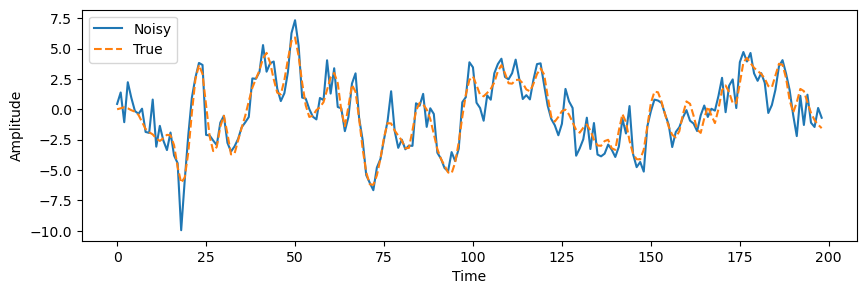

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(y_ss, label="Noisy")
plt.plot(y_og, "--", label="True")

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend();

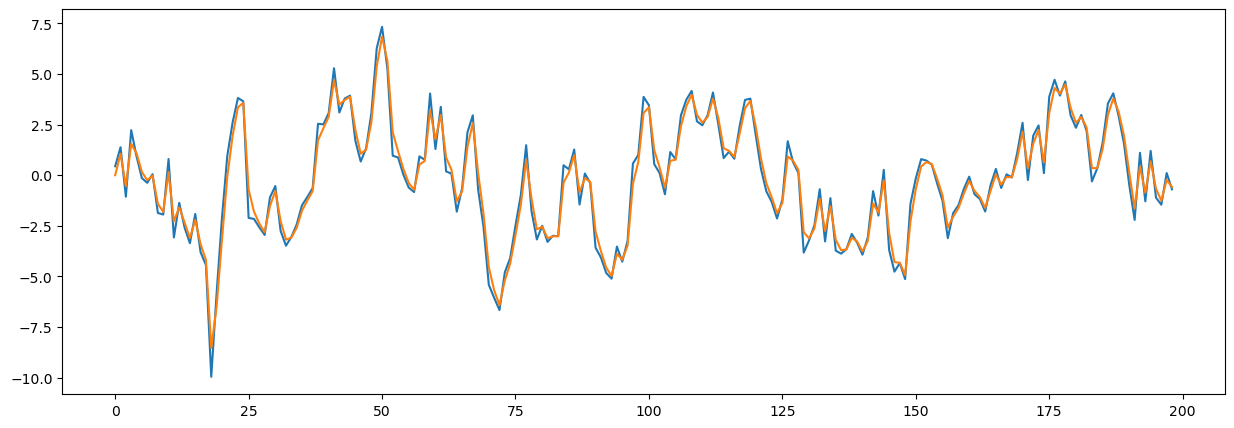

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(y_ss)
plt.plot(xhat);

### Noisy Sinusoid (LTV)

In [7]:
# Inspired by Matlab's tutorial at
# https://www.mathworks.com/help/control/ug/kalman-filtering.html
np.random.seed(1994)
q = 2.3
r = 1
s_rate = 0.5
sine_sig = lambda x: np.sin(x / 5)
time_vary = lambda x: -(0.5 * np.sin(x)) # Pseudo-Time-Varying transitions
x_t = np.arange(100)
x_resample = np.linspace(0, 100, num=199)
w_tv_noise = np.random.normal(0, np.sqrt(q), x_t.shape)

x_sine = sine_sig(x_t) + w_tv_noise

# State-Space Matrices
A = np.array([
    [1.1269, -0.4940, 0.1129],
    [1., 0., 0.],
    [0., 1., 0.],
])
B = np.array([
    [-0.3832], [0.5919], [0.5191],
])
# B = np.concatenate((B, B), axis=1)
C = np.array([1., 0., 0.])
D = 0

# Model the state as A * time_vary and regenerate the state space at each time step
state_mod_sig = time_vary(x_resample)
v_tv_noise = np.random.normal(0, np.sqrt(r), x_resample.shape)
y_ltv_og = np.zeros_like(x_resample)
for t_idx, pt in enumerate(state_mod_sig):
    A_t = A * pt
    ltv_ss = spysig.StateSpace(A_t, B, C, D, dt=s_rate)
    _, temp_y, _ = spysig.dlsim(ltv_ss, x_sine, x_t)

    y_ltv_og[t_idx] = temp_y[t_idx]

y_ltv_ss = y_ltv_og + v_tv_noise

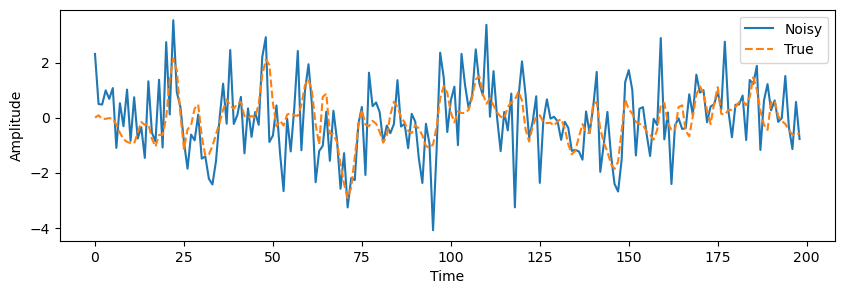

In [8]:
plt.figure(figsize=(10, 3))
plt.plot(y_ltv_ss, label="Noisy")
plt.plot(y_ltv_og, "--", label="True")

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend();

### Mackey-Glass

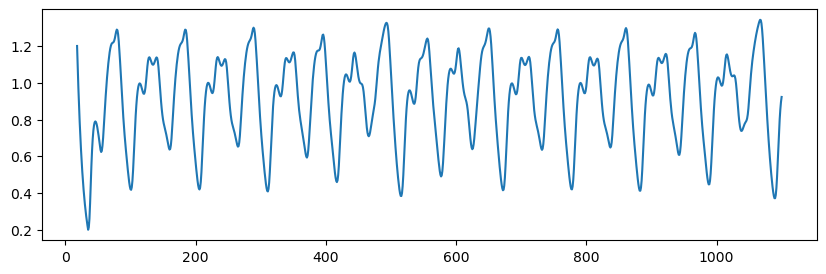

In [78]:
# Preset Mackey-Glass time series
t_min = 18
t_max = 1100

beta = 0.2
gamma = 0.1
tao = 17
n = 10

# =============================================================================
# Mackey-Glass time series
# =============================================================================
x = []
for i in range(1, t_min) :
    x.append(0.0)
x.append(1.2)

for t in range(t_min, t_max):
    h = x[t-1] + (beta * x[t-tao-1] / (1 + (x[t-tao-1]**n))) - (gamma * x[t-1])
    h = float("{:0.4f}".format(h))
    x.append(h)

# =============================================================================
# Plot Data
# =============================================================================
plt.figure(figsize=(10, 3))
plt.plot(range(t_min, t_max+1), x[t_min-1:t_max])

# =============================================================================
# Prepare Data
# =============================================================================
data = []
x = np.array(x[t_min-1:t_max])

for t in range(3, len(x)):
    d = []
    d.append(x[t-10])
    d.append(x[t])
    data.append(d)
mg_data = np.array(data)

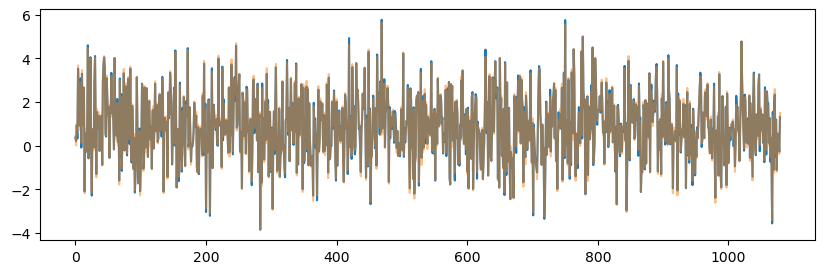

In [79]:
q = 2.3
w_mg_noise = np.random.normal(0, np.sqrt(q), mg_data.shape[0])
mg_data = mg_data[:, 0] + w_mg_noise

v_mg_noise = np.random.standard_normal(size=mg_data.shape[0]) / 8
y_mg_data = mg_data + v_mg_noise

plt.figure(figsize=(10, 3))
plt.plot(mg_data)
plt.plot(y_mg_data, alpha=0.5)

In [77]:
mg_data.shape

(1080,)

# Simple Kalman Filter

In [11]:
w_data = w_sine_noise
v_data = v_sine_noise
x_data = y_og
y_data = y_ss

I believe this is in the case of *complete* information on the system.

In [12]:
f = 1     # State-evolution
h = 1   # Observation modifier
q = np.var(w_data) # Variation of observation-corrupting noise
r = np.var(v_data) # Variation of state-evolution process

# Initialize KF parameters
x_est = np.zeros(x_data.shape[0])
y_err = np.zeros(x_data.shape[0])
y_err[0] = y_data[0] - h * x_est[0]   # initialize the first y_err

k_gain = 0
err_var = (y_err[0])**2
x_guess = x_est[0]
err_guess = err_var

# TODO - Make Extended Kalman Filter
for t in range(1, len(x_data)):
    state, obs = x_data[t], y_data[t]

    # Time Update
    x_est[t] = f * x_guess
    y_err[t] = y_data[t] - h * x_est[t]
    err_var = f * err_guess * f + q
    k_gain = f * (err_var * h) * (h * err_var * h + r)**-1

    # Information Update - x_{t|t} and Sigma_{t|t}
    x_guess = x_est[t] + k_gain * y_err[t]
    err_guess = err_var - k_gain * (h * err_var)

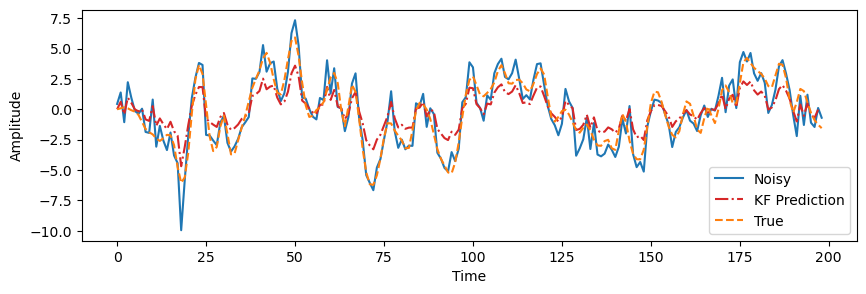

In [13]:
plt.figure(figsize=(10, 3))
plt.plot(y_data, label="Noisy")
plt.plot(x_est[1:], "-.", c='tab:red', label="KF Prediction")
plt.plot(x_data, "--", label="True")

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend();

In [14]:
x_data.shape, y_data.shape, x_est.shape

((199, 1), (199, 1), (199,))

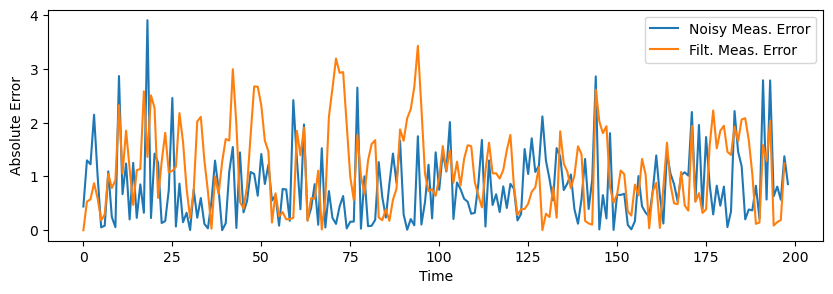

In [15]:
plt.plot(np.abs(x_data.squeeze() - y_data.squeeze()), label="Noisy Meas. Error")
plt.plot(np.abs(x_data[:-1].squeeze() - x_est[1:]), label="Filt. Meas. Error")
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend();

# FilterPy Kalman Filter(s)

In [84]:
w_data = w_mg_noise[:200]
v_data = v_mg_noise[:200]
x_data = mg_data[:200]
y_data = y_mg_data[:200]

In [95]:
f = 1     # State-evolution
h = 0.8   # Observation modifier
dt = 0.1

poly_fn_t = lambda x, dt: f*(dt*x + (dt*x)**2 + (dt*x)**3)
poly_fn = lambda x: h*(x + x**2 + x**3)
points = py_kf.sigma_points.MerweScaledSigmaPoints(1, alpha=.1, beta=2., kappa=2)
ukf = py_kf.UnscentedKalmanFilter(dim_x=1, dim_z=1, dt=dt, hx=poly_fn, fx=poly_fn_t, points=points)

# Initialize KF parameters
x_est = np.zeros(x_data.shape[0])
y_err = np.zeros(x_data.shape[0])
y_err[0] = y_data[0] - h * x_est[0]   # initialize the first y_err

k_gain = 0
ukf.P *= (y_err[0])**2
ukf.R = np.array([np.var(w_data)])
ukf.Q = np.array([np.var(v_data)])
ukf.x = x_est[0]

for t in range(1, len(x_data)):
    ukf.predict()
    ukf.update(y_data[t])

    x_est[t] = ukf.x.squeeze()
    y_err[t] = y_data[t] - h * x_est[t]

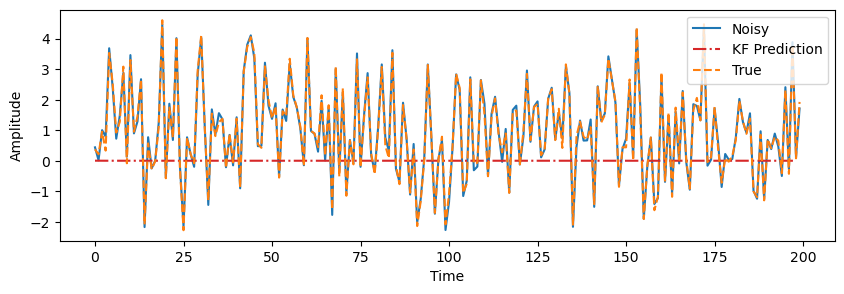

In [96]:
plt.figure(figsize=(10, 3))
plt.plot(y_data, label="Noisy")
plt.plot(x_est[1:], "-.", c='tab:red', label="KF Prediction")
plt.plot(x_data, "--", label="True")

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend();

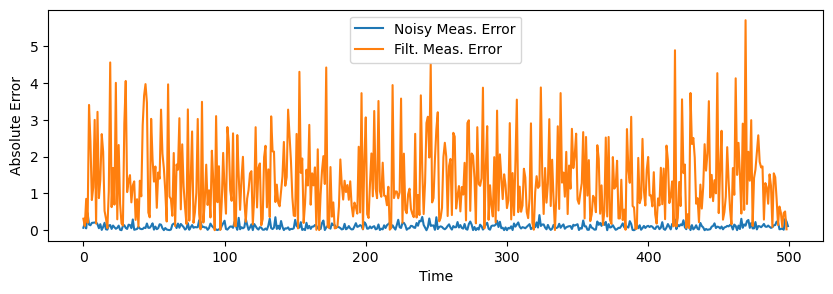

In [83]:
plt.plot(np.abs(x_data.squeeze() - y_data.squeeze()), label="Noisy Meas. Error")
plt.plot(np.abs(x_data[:-1].squeeze() - x_est[1:]), label="Filt. Meas. Error")
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend();